In [2]:
# for loading and analyzing the dataframe.
import pandas as pd
# Step 1: fbprophet will make the future forcasts.
# Step 2: With pyod we'll determine the outliers in the forcast.
import fbprophet, pyod
import matplotlib.pyplot as plt

In [152]:
# pyod algorithm selection related import statements.
from pyod.models.lscp import LSCP
from pyod.models.lof import LOF
from pyod.models.cblof import CBLOF
from pyod.models.loda import LODA
# for evaluating the model performance in terms of Mean Absolute Error.
from sklearn.metrics import mean_absolute_error

## Methodology of Predictive Outlier Analysis of Server Data

__This is a two step pipeline that is designed to first forecast the behavior of each variable independent of another. This independence amongst variables is a reasonable assumption and appropriate analytics decision while making the predictions for the future data i.e. forecasting target variables. And from the same forecasted variables are fed in combined manner to our unsupervised outlier detection ensemble algorithm.__  

__Below, we state the exact steps followed for the modelling and prediction process:__  

* Loading the dataset onto dataframes. Here, we have decided to work with `multi-var-four-two.csv` which describes the scenario or state features for a given single EC2 AWS VM.
* Second, we separate these variables and feed them individually for prediction into `fbprophet` addition based models. Also, we keep our forecasting range to be `4.5 days` as knowing the defect almost 1 working week earlier is more than enough time to take suitable actions for ramifications.
  * After training the model and making a forecast we do evaluate the accuracy of the model.
* After making the forecasts we use the same data for training out `pyod` outlier models from the previous training data split of `3024th` row number.
  * After training the model and making outlier predictions. We quantitatively analyze the output results by comparing outlier prediction values on actual and forecasted data in this notebook.

### Standardizing the model data, visualizing it and preparing train-test data splits.

In [61]:
vm_df = pd.read_csv('nab-sample-data-subset/multi-var-four-two.csv')

In [46]:
vm_df.head()

,timestamp,net_util_ec2_one,cpu_util_ec2_one,req_count_ec2_one,rds_util_ec2_one
0,2014-04-10 00:04:00,251643.0,91.958,94.0,14.012
1,2014-04-10 00:09:00,3203510.0,94.798,56.0,13.334
2,2014-04-10 00:14:00,287397.0,92.208,187.0,15.000
3,2014-04-10 00:19:00,238944.0,93.722,95.0,13.998
4,2014-04-10 00:24:00,245880.0,93.042,51.0,14.332


In [5]:
vm_df.describe()

,net_util_ec2_one,cpu_util_ec2_one,req_count_ec2_one,rds_util_ec2_one
count,4.032000e+03,4032.000000,4032.000000,4032.000000
mean,5.708099e+05,89.791262,61.837054,18.934868
std,4.607793e+06,12.078708,56.664703,5.605191
min,3.851660e+04,18.722500,1.000000,12.628000
25%,2.193418e+05,89.081000,15.000000,15.835000
50%,2.342455e+05,92.449000,48.000000,16.677500
75%,2.517748e+05,94.299500,89.000000,25.521250
max,2.451260e+08,99.118000,656.000000,76.230000


In [62]:
# Now, standardizing the numerical values and doing a value analysis again.
vm_df.loc[:, 'net_util_ec2_one':] = (vm_df.loc[:,'net_util_ec2_one':]-vm_df.loc[:,'net_util_ec2_one':].min())/(vm_df.loc[:,'net_util_ec2_one':].max()-vm_df.loc[:,'net_util_ec2_one':].min())

In [13]:
vm_df.head()

,timestamp,net_util_ec2_one,cpu_util_ec2_one,req_count_ec2_one,rds_util_ec2_one
0,2014-04-10 00:04:00,0.000870,0.910940,0.141985,0.021760
1,2014-04-10 00:09:00,0.012914,0.946266,0.083969,0.011100
2,2014-04-10 00:14:00,0.001015,0.914050,0.283969,0.037294
3,2014-04-10 00:19:00,0.000818,0.932882,0.143511,0.021540
4,2014-04-10 00:24:00,0.000846,0.924424,0.076336,0.026792


In [14]:
vm_df.describe()

,net_util_ec2_one,cpu_util_ec2_one,req_count_ec2_one,rds_util_ec2_one
count,4032.000000,4032.000000,4032.000000,4032.000000
mean,0.002172,0.883989,0.092881,0.099161
std,0.018801,0.150241,0.086511,0.088129
min,0.000000,0.000000,0.000000,0.000000
25%,0.000738,0.875155,0.021374,0.050423
50%,0.000799,0.917048,0.071756,0.063669
75%,0.000870,0.940065,0.134351,0.202718
max,1.000000,1.000000,1.000000,1.000000


In [59]:
# Converting to datatype to timestamp for analysis.
vm_plot = pd.read_csv('nab-sample-data-subset/multi-var-four-two.csv')
vm_plot.loc[:, 'net_util_ec2_one':] = (vm_plot.loc[:,'net_util_ec2_one':]-vm_plot.loc[:,'net_util_ec2_one':].min())/(vm_plot.loc[:,'net_util_ec2_one':].max()-vm_plot.loc[:,'net_util_ec2_one':].min())
vm_plot['timestamp']= pd.to_datetime(vm_plot['timestamp'])
vm_plot.set_index('timestamp', inplace=True)

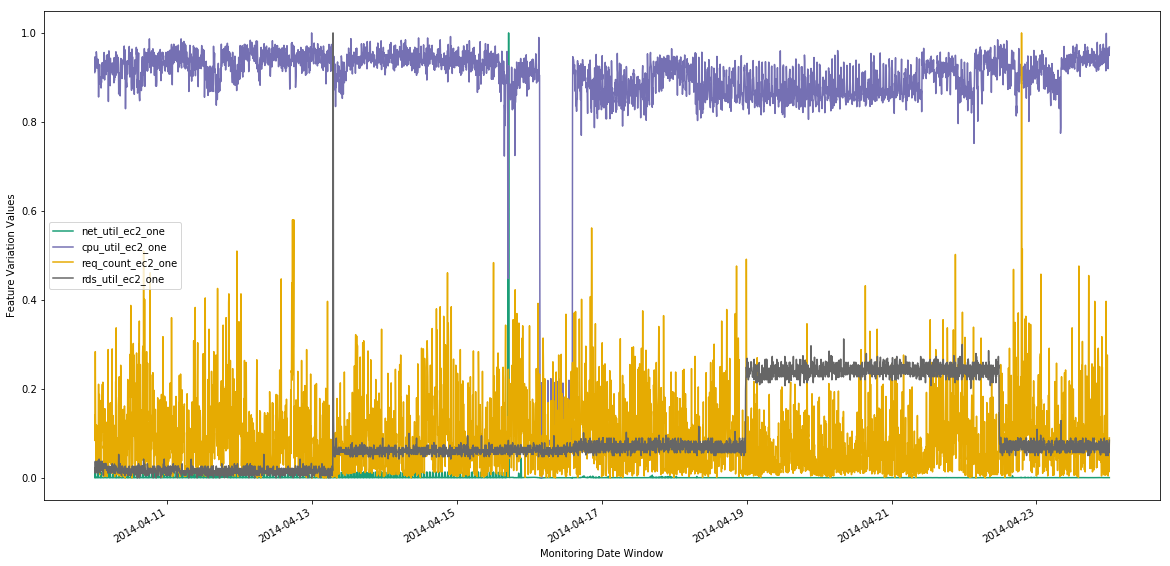

In [60]:
ax = vm_plot.plot(colormap='Dark2', figsize=(20, 10))
ax.set_xlabel('Monitoring Date Window')
ax.set_ylabel('Feature Variation Values')
plt.show()
# We clearly have very interesting forecasting functions available to us for prediction.

In [66]:
# changing the 'timestamp' field to datetime type
vm_df['timestamp']= pd.to_datetime(vm_df['timestamp'])

# creating a train-test split for approximately 8.5 days forecast window.
train_vm_df = vm_df[:3024]
test_vm_df = vm_df[3024:]

In [67]:
net_train = train_vm_df[['timestamp','net_util_ec2_one']]
cpu_train = train_vm_df[['timestamp','cpu_util_ec2_one']]
count_train = train_vm_df[['timestamp','req_count_ec2_one']]
rds_train = train_vm_df[['timestamp','rds_util_ec2_one']]

In [68]:
net_train.columns = ['ds', 'y']
cpu_train.columns = ['ds', 'y']
count_train.columns = ['ds', 'y']
rds_train.columns = ['ds', 'y']

In [75]:
net_test = test_vm_df[['timestamp','net_util_ec2_one']]
cpu_test = test_vm_df[['timestamp','cpu_util_ec2_one']]
count_test = test_vm_df[['timestamp','req_count_ec2_one']]
rds_test = test_vm_df[['timestamp','rds_util_ec2_one']]

net_test.columns = ['ds', 'y']
cpu_test.columns = ['ds', 'y']
count_test.columns = ['ds', 'y']
rds_test.columns = ['ds', 'y']

### Model forecasts for every variable independently under consideration for VM under analysis.

In [73]:
# declaring different models for variable forecasting
model_net_util = fbprophet.Prophet()
model_net_util.fit(net_train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


In [79]:
net_fut = pd.DataFrame(net_test['ds'])
net_forecast = model_net_util.predict(net_fut)

/home/ashishrana160796/.local/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/home/ashishrana160796/.local/lib/python3.6/site-packages/matplotlib/axes/_base.py:239: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/home/ashishrana160796/.local/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



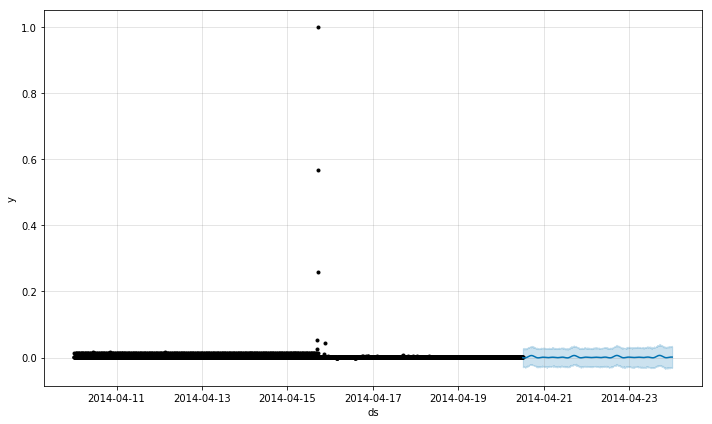

In [83]:
fig1 = model_net_util.plot(net_forecast)
fig1.show()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
/home/ashishrana160796/.local/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/home/ashishrana160796/.local/lib/python3.6/site-packages/matplotlib/axes/_base.py:239: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/home/ashishrana160796/.local/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



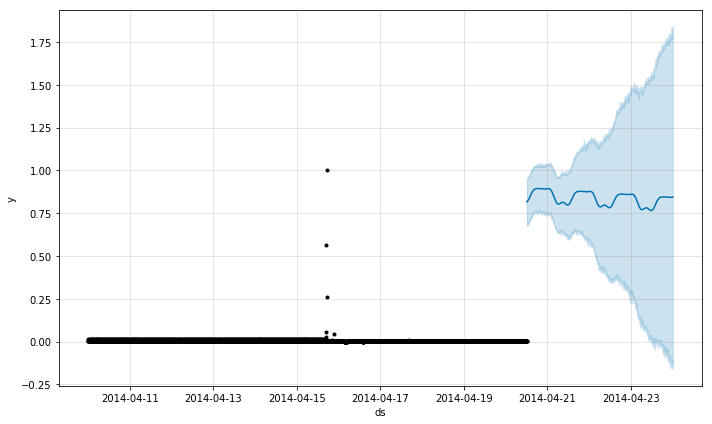

In [84]:
# cpu utilization forecasting.

# declaring different models for variable forecasting
model_cpu_util = fbprophet.Prophet()
model_cpu_util.fit(cpu_train)

# Making forecasts for CPU utilization
cpu_fut = pd.DataFrame(cpu_test['ds'])
cpu_forecast = model_cpu_util.predict(cpu_fut)

fig1 = model_net_util.plot(cpu_forecast)
fig1.show()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
/home/ashishrana160796/.local/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/home/ashishrana160796/.local/lib/python3.6/site-packages/matplotlib/axes/_base.py:239: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/home/ashishrana160796/.local/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



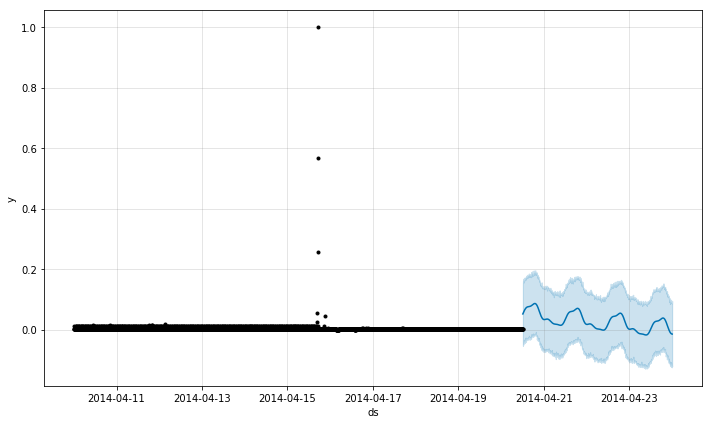

In [85]:
# count request forecasting.

# declaring different models for variable forecasting
model_count_util = fbprophet.Prophet()
model_count_util.fit(count_train)

# Making forecasts for count requests
count_fut = pd.DataFrame(count_test['ds'])
count_forecast = model_count_util.predict(count_fut)

fig1 = model_net_util.plot(count_forecast)
fig1.show()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
/home/ashishrana160796/.local/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/home/ashishrana160796/.local/lib/python3.6/site-packages/matplotlib/axes/_base.py:239: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/home/ashishrana160796/.local/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



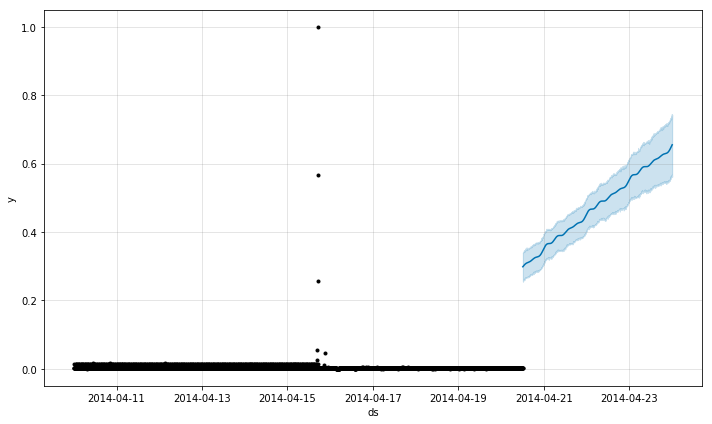

In [86]:
# rds utilization forecasting.

# declaring different models for variable forecasting
model_rds_util = fbprophet.Prophet()
model_rds_util.fit(rds_train)

# Making forecasts for rds utilization
rds_fut = pd.DataFrame(rds_test['ds'])
rds_forecast = model_rds_util.predict(rds_fut)

fig1 = model_net_util.plot(rds_forecast)
fig1.show()

### Metric based evaluation of models under consideration for given features and visualizing them.

In [91]:
# MAE evaluation for all the forecasts that are made.
print("Network Utilization MAE: "+ str(mean_absolute_error(net_test['y'], net_forecast['yhat'])) )
print("CPU Utilization MAE: "+ str(mean_absolute_error(cpu_test['y'], cpu_forecast['yhat'])) )
print("Request Count MAE: "+ str(mean_absolute_error(count_test['y'], count_forecast['yhat'])) )
print("RDS Utilization MAE: "+ str(mean_absolute_error(rds_test['y'], rds_forecast['yhat'])) )
# Really accurate values of forecasting.

Network Utilization MAE: 0.001306743786168312
CPU Utilization MAE: 0.07774488757377451
Request Count MAE: 0.07923446136651222
RDS Utilization MAE: 0.3072047992188164


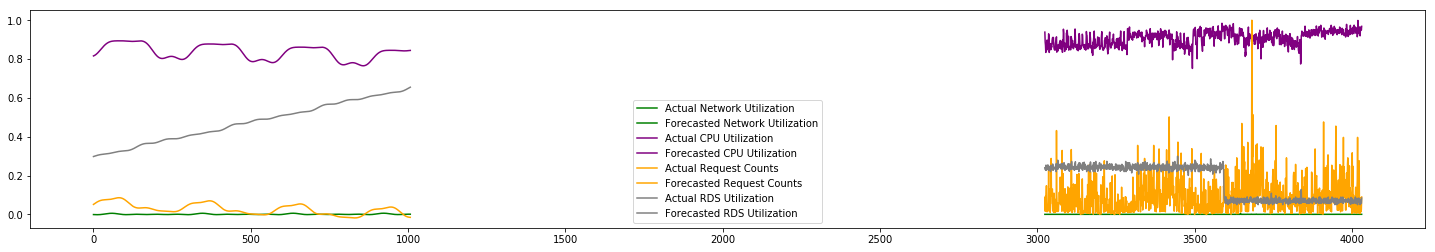

In [150]:
# Plotting the actul vs forecast data.
plt.rcParams["figure.figsize"] = (25,4)

plt.plot(net_test['y'], label='Actual Network Utilization', color='green')
plt.plot(net_forecast['yhat'], label='Forecasted Network Utilization', color='green')

plt.plot(cpu_test['y'], label='Actual CPU Utilization', color = 'purple')
plt.plot(cpu_forecast['yhat'], label='Forecasted CPU Utilization', color = 'purple' )

plt.plot(count_test['y'], label='Actual Request Counts', color = 'orange')
plt.plot(count_forecast['yhat'], label='Forecasted Request Counts', color = 'orange' )

plt.plot(rds_test['y'], label='Actual RDS Utilization', color = 'grey')
plt.plot(rds_forecast['yhat'], label='Forecasted RDS Utilization', color = 'grey' )

plt.legend()
plt.show()

### Outlier analysis on forecasted data & sanity check.

__If the outlier predictions made on forecasted data shows different result in comparison to outier predictions made on actual data then making predictions further in time is not a feasable option.__

In [115]:
# dataframe already available to us for model training
# train_vm_df, test_vm_df.
# create a forcast time frame for analysis.

forcasted_data = [net_forecast['yhat'], cpu_forecast['yhat'], count_forecast['yhat'], rds_forecast['yhat']]
headers = ['net_util_ec2_one', 'cpu_util_ec2_one' , 'req_count_ec2_one', 'rds_util_ec2_one']
forcast_df = pd.concat(forcasted_data, axis=1, keys=headers)

In [116]:
forcast_df.head()

,net_util_ec2_one,cpu_util_ec2_one,req_count_ec2_one,rds_util_ec2_one
0,-0.000406,0.816278,0.051819,0.298399
1,-0.000503,0.816914,0.052960,0.298943
2,-0.000596,0.817643,0.054098,0.299488
3,-0.000683,0.818462,0.055232,0.300030
4,-0.000764,0.819372,0.056356,0.300568


In [153]:
detector_list = [ LOF(n_neighbors=16), LOF(n_neighbors=24),
                     CBLOF(random_state=42), LODA() ]

In [154]:
clf_org = LSCP(detector_list, random_state=42)
clf_org.fit(train_vm_df.loc[:,"net_util_ec2_one":])

/usr/local/lib/python3.6/dist-packages/pyod/models/lscp.py:376: UserWarning:

The number of histogram bins is greater than the number of classifiers, reducing n_bins to n_clf.

/home/ashishrana160796/.local/lib/python3.6/site-packages/scipy/stats/stats.py:3038: RuntimeWarning:

invalid value encountered in double_scalars

/home/ashishrana160796/.local/lib/python3.6/site-packages/scipy/stats/stats.py:3049: RuntimeWarning:

invalid value encountered in double_scalars



LSCP(contamination=0.1,
   detector_list=[LOF(algorithm='auto', contamination=0.1, leaf_size=30, metric='minkowski',
  metric_params=None, n_jobs=1, n_neighbors=16, p=2), LOF(algorithm='auto', contamination=0.1, leaf_size=30, metric='minkowski',
  metric_params=None, n_jobs=1, n_neighbors=24, p=2), CBLOF(alpha=0.9, beta=5, check_estimator=False, clustering_estimator=None,
   contamination=0.1, n_clusters=8, n_jobs=1, random_state=42,
   use_weights=False), LODA(contamination=0.1, n_bins=10, n_random_cuts=100)],
   local_max_features=1.0, local_region_size=30, n_bins=4,
   random_state=RandomState(MT19937) at 0x7F4A8BC69888)

In [155]:
pred_org = clf_org.predict_proba(test_vm_df.loc[:,"net_util_ec2_one":])

/home/ashishrana160796/.local/lib/python3.6/site-packages/scipy/stats/stats.py:3038: RuntimeWarning:

invalid value encountered in double_scalars

/home/ashishrana160796/.local/lib/python3.6/site-packages/scipy/stats/stats.py:3049: RuntimeWarning:

invalid value encountered in double_scalars

/home/ashishrana160796/.local/lib/python3.6/site-packages/scipy/stats/stats.py:3033: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/home/ashishrana160796/.local/lib/python3.6/site-packages/scipy/stats/stats.py:3034: RuntimeWarning:

Mean of empty slice.



In [156]:
pred_for = clf_org.predict_proba(forcast_df)

In [157]:
# Sanity check on prediction variation metric
for_pred = pred_for[:,0].tolist()
org_pred = pred_org[:,0].tolist()

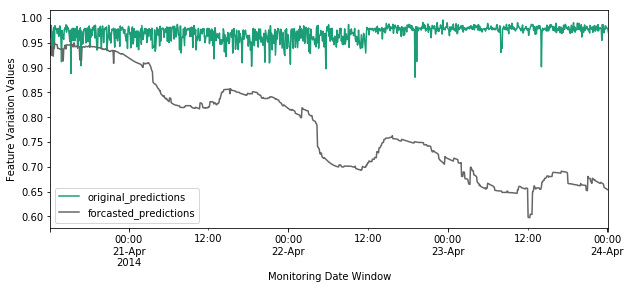

In [158]:
# Plotting the actul vs forecast data.

pred_plot_df = pd.DataFrame(list(zip(test_vm_df['timestamp'], org_pred, for_pred)), 
               columns =['timestamp', 'original_predictions', 'forcasted_predictions'])

pred_plot_df['timestamp']= pd.to_datetime(pred_plot_df['timestamp'])
pred_plot_df.set_index('timestamp', inplace=True)

ax = pred_plot_df.plot(colormap='Dark2', figsize=(10, 4))
ax.set_xlabel('Monitoring Date Window')
ax.set_ylabel('Feature Variation Values')
plt.show()

In [159]:
# Model performance sanity check establish.
print("Sanity Check Evaluation half day: "+ str(mean_absolute_error( for_pred[:143], org_pred[:143] )) )
print("Sanity Check Evaluation one day: "+ str(mean_absolute_error( for_pred[:287], org_pred[:287] )) )
print("Sanity Check Evaluation three days: "+ str(mean_absolute_error( for_pred[:861], org_pred[:861] )) )
print("Sanity Check Evaluation four and half days: "+ str(mean_absolute_error( for_pred, org_pred )) )

Sanity Check Evaluation half day: 0.03270968074605652
Sanity Check Evaluation one day: 0.07351063800487506
Sanity Check Evaluation three days: 0.17144583917568554
Sanity Check Evaluation four and half days: 0.19182688468024553
